# CNN Klasifikasi Gambar dengan Transfer Learning

## Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import pickle
from glob import glob
import matplotlib.pyplot as plt

In [3]:
import zipfile
import os
import matplotlib.pyplot as plt

zip_path = '/content/drive/My Drive/Air Quality.zip'
extract_path = '/content/extracted'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File zip berhasil diekstrak!")


File zip berhasil diekstrak!


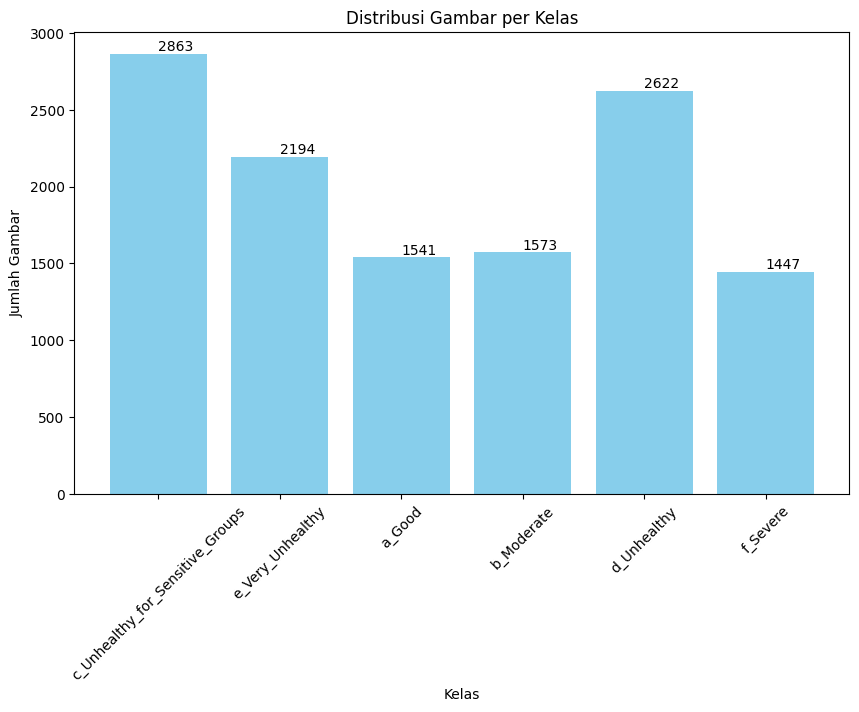

In [18]:
extract_path = '/content/extracted'

data_dir = os.path.join(extract_path, 'Air Quality')
classes = os.listdir(data_dir)

class_counts = {}
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Gambar per Kelas')
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # Add text on top of each bar

plt.show()

## Data untuk Pemodelan

In [4]:
import pandas as pd

base_path = '/content/extracted/Air Quality'
categories = ['a_Good', 'b_Moderate', 'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 'e_Very_Unhealthy', 'f_Severe']

data = []

for category in categories:
    folder_path = os.path.join(base_path, category)
    filenames = os.listdir(folder_path)
    for filename in filenames:
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add other image extensions if needed
            file_path = os.path.join(folder_path, filename)
            data.append({'Filename': filename, 'Pollution': category, 'Actual_Path': file_path})

df = pd.DataFrame(data)

# Encode the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Pollution'] = le.fit_transform(df['Pollution'])

df.head()


,Filename,Pollution,Actual_Path
0,BENGR_Good_2023-02-27-08.30-1-41.jpg,0,/content/extracted/Air Quality/a_Good/BENGR_Go...
1,BENGR_Good_2023-03-21-08.30-1-50.jpg,0,/content/extracted/Air Quality/a_Good/BENGR_Go...
2,BENGR_Good_2023-02-19-08.30-1-13.jpg,0,/content/extracted/Air Quality/a_Good/BENGR_Go...
3,BENGR_Good_2023-02-19-08.30-1-34.jpg,0,/content/extracted/Air Quality/a_Good/BENGR_Go...
4,TN_Good_2023-03-21-08.30-1-50.jpg,0,/content/extracted/Air Quality/a_Good/TN_Good_...


In [5]:
pickle.dump(le, open('/content/drive/MyDrive/Colab Notebooks/Pollution_le.pkl','wb'))

In [12]:
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, df, batch_size=32, target_size=(128, 128), shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch = [self.df.iloc[i] for i in indices]
        X, y = self.__data_generation(batch)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch):
        X_pic = []
        y = []

        for row in batch:
            picture_path = row['Actual_Path']

            if not os.path.isfile(picture_path):
                print(f"Warning: File {picture_path} does not exist.")
                continue

            pic = cv2.imread(picture_path)

            if pic is None:
                print(f"Warning: Image at path {picture_path} could not be loaded.")
                continue

            pic = cv2.resize(pic, self.target_size)  # Resize image
            pic = pic / 255.0  # Normalize
            X_pic.append(pic)

            output = np.array(row['Pollution'])
            y.append(output)

        X_pic = np.array(X_pic)
        y = np.array(y)

        return X_pic, y

shuffled_df = df.sample(frac=1).reset_index(drop=True)
train_df, val_df, test_df = shuffled_df[:8000], shuffled_df[8000:10000], shuffled_df[10000:]

# Example usage:
train_generator = DataGenerator(train_df)
val_generator = DataGenerator(val_df)
test_generator = DataGenerator(test_df)


Sample images from training data:


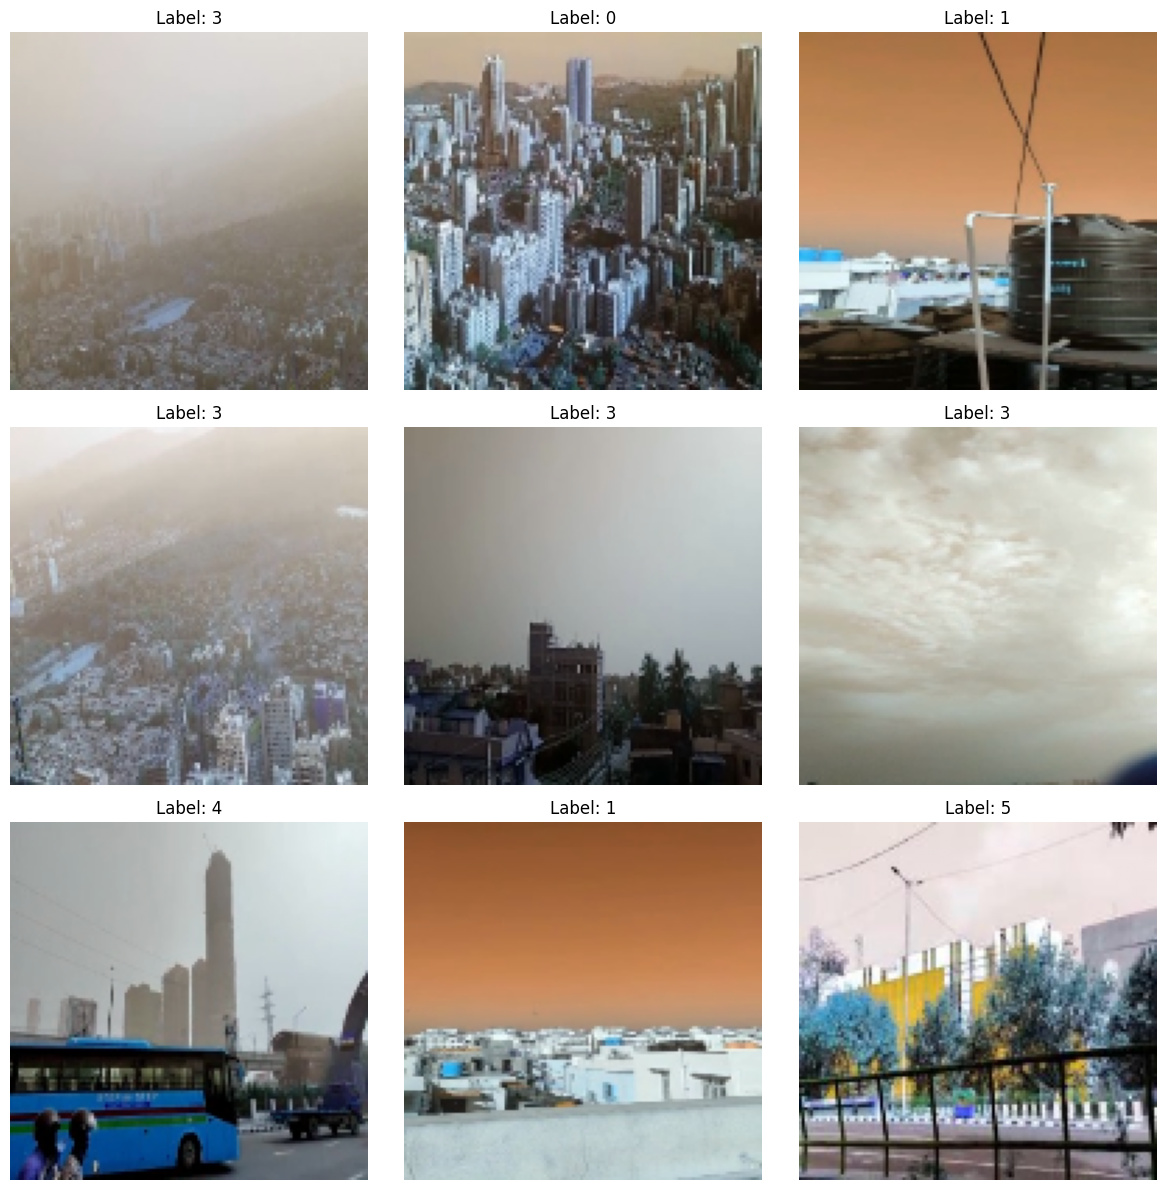

Sample images from validation data:


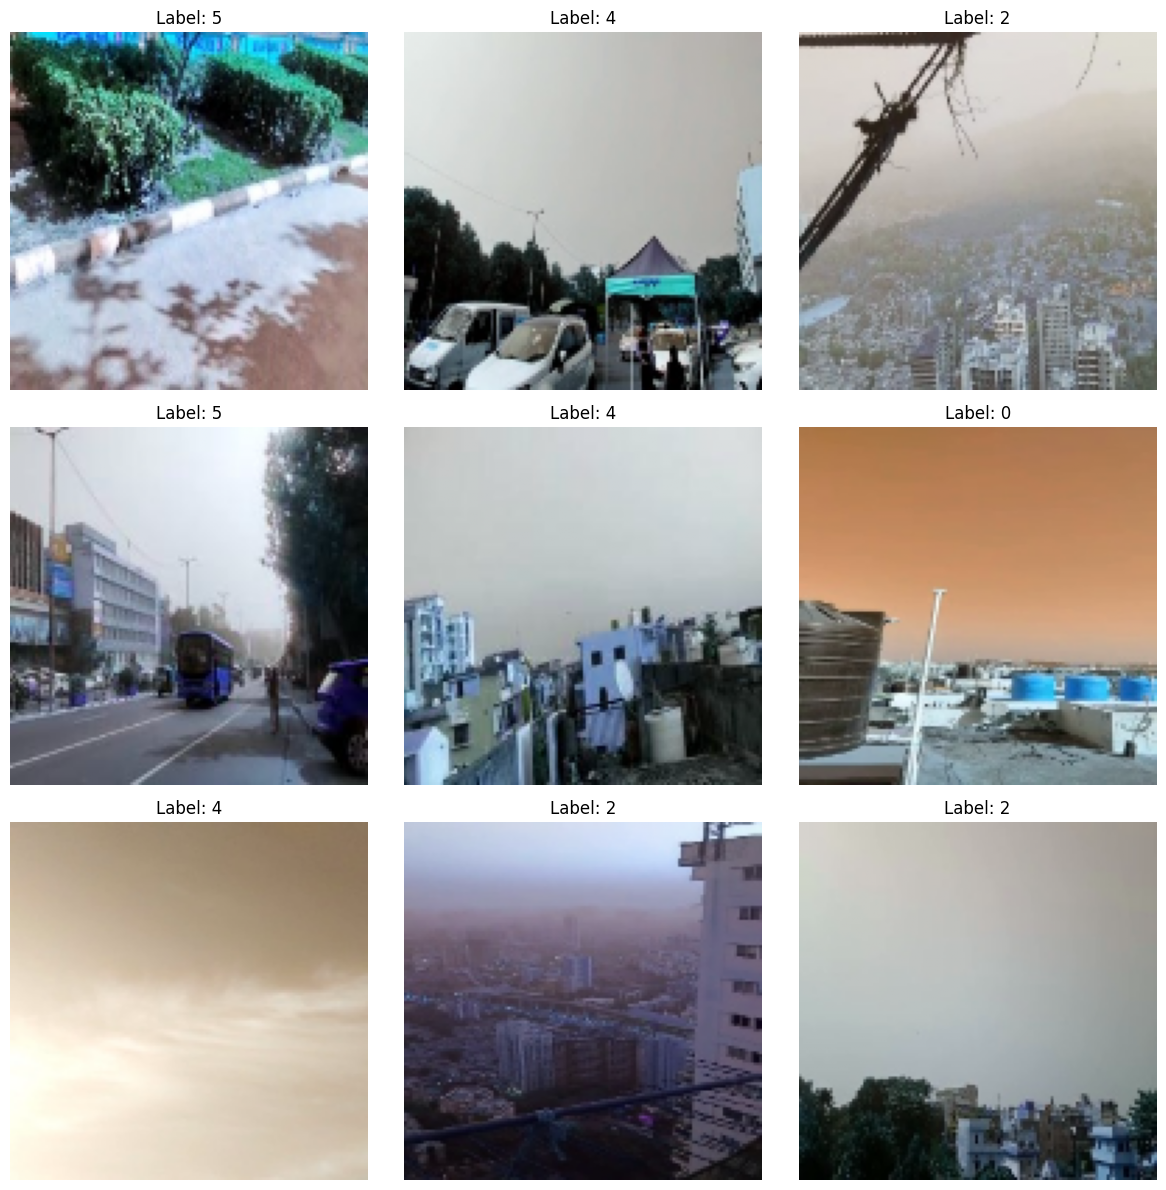

In [54]:
import matplotlib.pyplot as plt

def plot_sample_images(generator, num_samples=9):
    """Function to plot sample images from a data generator."""
    # Get a batch of data
    X, y = generator.__getitem__(0)

    # Determine the grid size
    grid_size = int(np.ceil(np.sqrt(num_samples)))

    # Create a figure
    plt.figure(figsize=(12, 12))

    for i in range(num_samples):
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(X[i])
        plt.title(f'Label: {y[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
train_generator = DataGenerator(train_df, batch_size=9)  # Using a small batch size to easily fetch a few samples
val_generator = DataGenerator(val_df, batch_size=9)     # Same for validation generator

# Plot sample images from the training generator
print("Sample images from training data:")
plot_sample_images(train_generator)

# Plot sample images from the validation generator
print("Sample images from validation data:")
plot_sample_images(val_generator)


## Pembentukan model

In [6]:
IMAGE_SIZE = [128,128]

In [7]:
vgg16 = VGG16(input_shape = IMAGE_SIZE+[3],weights='imagenet',include_top=False)

In [8]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [9]:
for layer in vgg16.layers:
  layer.trainable= False


x = Flatten()(vgg16.output)
prediction = Dense(6,activation='softmax')(x)
model = Model(inputs=vgg16.input , outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

## Training model

In [10]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
cp = ModelCheckpoint('model/',save_best_only = True)

In [14]:

history = model.fit(train_generator,
              validation_data=val_generator,
              epochs=10,
              callbacks=[cp])

Epoch 1/10
250/250 [==============================] - 30s 95ms/step - loss: 0.9590 - accuracy: 0.6376 - val_loss: 0.6961 - val_accuracy: 0.7621
Epoch 2/10
250/250 [==============================] - 25s 101ms/step - loss: 0.5321 - accuracy: 0.8281 - val_loss: 0.4994 - val_accuracy: 0.8332
Epoch 3/10
250/250 [==============================] - 22s 86ms/step - loss: 0.3989 - accuracy: 0.8816 - val_loss: 0.4300 - val_accuracy: 0.8513
Epoch 4/10
250/250 [==============================] - 22s 90ms/step - loss: 0.3155 - accuracy: 0.9125 - val_loss: 0.3569 - val_accuracy: 0.8846
Epoch 5/10
250/250 [==============================] - 20s 78ms/step - loss: 0.2660 - accuracy: 0.9302 - val_loss: 0.3055 - val_accuracy: 0.9062
Epoch 6/10
250/250 [==============================] - 22s 87ms/step - loss: 0.2283 - accuracy: 0.9435 - val_loss: 0.2663 - val_accuracy: 0.9204
Epoch 7/10
250/250 [==============================] - 21s 84ms/step - loss: 0.1996 - accuracy: 0.9528 - val_loss: 0.2616 - val_accuracy

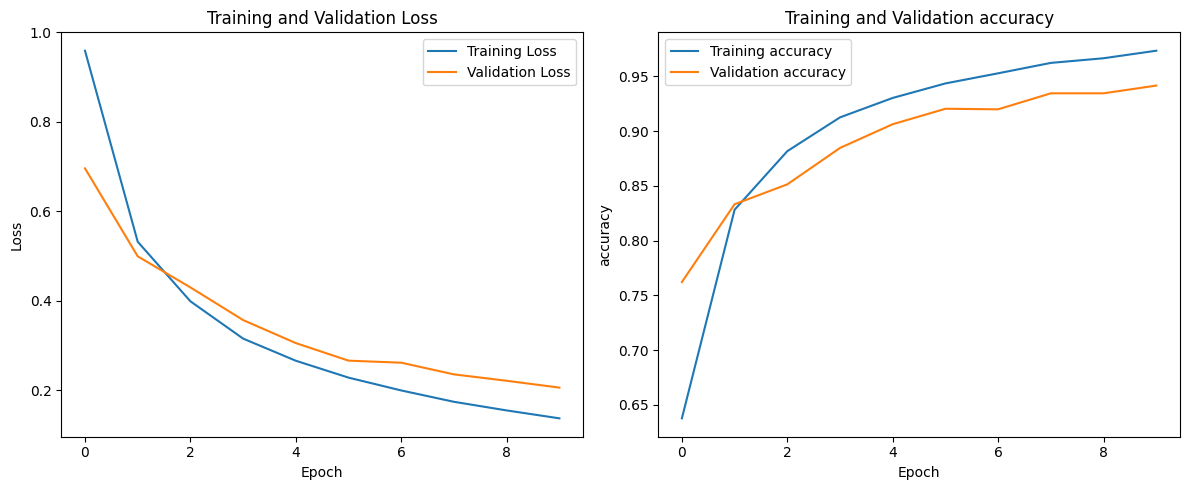

In [24]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Function to plot the training history for loss and accuracy."""
    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(r)


## Prediksi

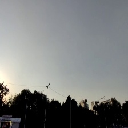

In [66]:
test_img = load_img('/content/extracted/Air Quality/e_Very_Unhealthy/DEL_VUH_2023-02-04-17.00-2-101.jpg',target_size = (128,128))
test_img


In [67]:
#ubah ke array
test_img_array = image.img_to_array(test_img)

# normalisasi
test_img_array = test_img_array / 255.0

# cocokin dimensi input
test_img_array = np.expand_dims(test_img_array, axis=0)

test_img_array.shape

(1, 128, 128, 3)

In [68]:

prediction = model.predict(test_img_array)

print(f"Prediction shape: {prediction.shape}")
print(f"Prediction output: {prediction}")

predicted_class_index = np.argmax(prediction[0])
predicted_class_label = le.inverse_transform([predicted_class_index])

print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class label: {predicted_class_label[0]}")

1/1 [==============================] - 0s 20ms/step
Prediction shape: (1, 6)
Prediction output: [[0.1269119  0.00283441 0.03667406 0.01374325 0.79353565 0.02630071]]
Predicted class index: 4
Predicted class label: e_Very_Unhealthy


In [56]:
model.save('imgmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Prediksi semua data test

In [69]:
test_df

,Filename,Pollution,Actual_Path
10000,TN_UnFSG_2023-03-02-08.30-1-81.jpg,2,/content/extracted/Air Quality/c_Unhealthy_for...
10001,BIR_UFSG_2023-02-14- 14.30-1-5.jpg,2,/content/extracted/Air Quality/c_Unhealthy_for...
10002,BIR_UNH_VF_2023-02-02- 15.00-2-2.jpg,3,/content/extracted/Air Quality/d_Unhealthy/BIR...
10003,UP_SEV_2023-02-20-08.30-1-5.jpg,5,/content/extracted/Air Quality/f_Severe/UP_SEV...
10004,UP_VUN_2023-03-02-09.00-1-509.jpg,4,/content/extracted/Air Quality/e_Very_Unhealth...
...,...,...,...
12235,TN_MOD_2023-02-09-08.30-2-3.jpg,1,/content/extracted/Air Quality/b_Moderate/TN_M...
12236,MH_UnFSG_2023-02-16-17.00-3.jpg,2,/content/extracted/Air Quality/c_Unhealthy_for...
12237,BIR_UNH_VF_2023-02-03- 10.00-3-53.jpg,3,/content/extracted/Air Quality/d_Unhealthy/BIR...
12238,UP_VUN_2023-02-27-10.30-1-301.jpg,4,/content/extracted/Air Quality/e_Very_Unhealth...


In [71]:
def preprocess_images(df, target_size=(128, 128)):
    X = []
    y = []

    for i, row in df.iterrows():
        img_path = row['Actual_Path']
        img = load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img) / 255.0
        X.append(img_array)
        y.append(row['Pollution'])

    return np.array(X), np.array(y)

X_test, y_test = preprocess_images(test_df)

In [72]:
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)


70/70 [==============================] - 3s 42ms/step


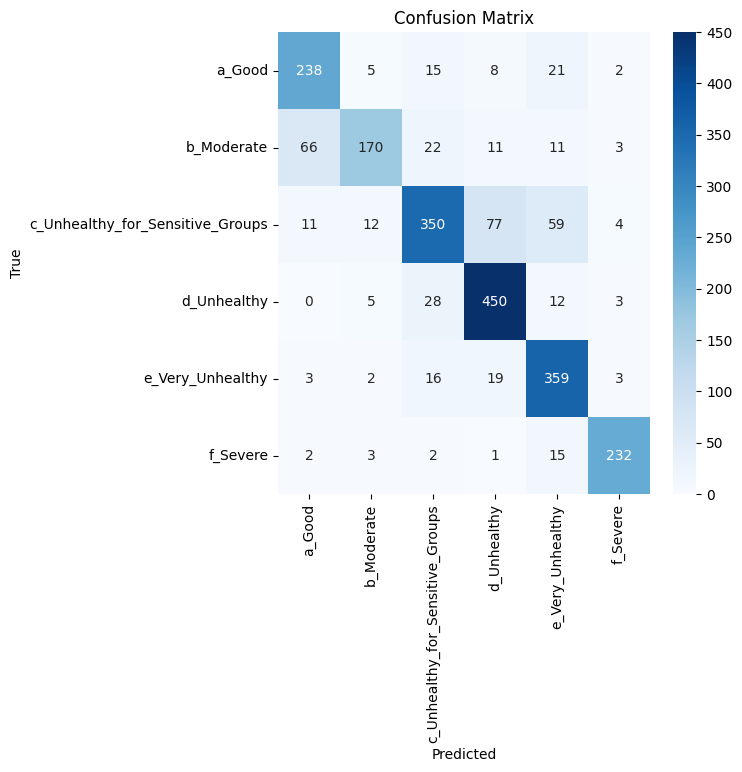

                                  precision    recall  f1-score   support

                          a_Good       0.74      0.82      0.78       289
                      b_Moderate       0.86      0.60      0.71       283
c_Unhealthy_for_Sensitive_Groups       0.81      0.68      0.74       513
                     d_Unhealthy       0.80      0.90      0.85       498
                e_Very_Unhealthy       0.75      0.89      0.82       402
                        f_Severe       0.94      0.91      0.92       255

                        accuracy                           0.80      2240
                       macro avg       0.82      0.80      0.80      2240
                    weighted avg       0.81      0.80      0.80      2240



In [74]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_classes, target_names=le.classes_))
